# PS2: IV estimation
This notebook illustrates how to use instrumental variable (IV) estimation to estimate the causal effect of monetary policy shocks on output growth.

# IV estimation with 2SLS
The Two-Stage Least Squares (2SLS) method is an approach used to compute Instrumental Variable (IV) estimates. The procedure works in two steps.

#### Stage 1

In the first step, each explanatory variable, which is an endogenous in the main equation, is regressed on all the exogenous variables in the model. This includes both the exogenous variables in the main equation and the instruments. 
$$
\mathbf{X} = \mathbf{Z}\delta + \mathbf{e}
$$

and obtain the estimated coefficients using OLS,

$$
\hat{\delta} = (Z'Z)^{-1}Z'X
$$

The predicted values from these regressions are then obtained.
$$
\mathbf{\hat{X}} = \mathbf{Z}\hat{\delta} = Z(Z'Z)^{-1}Z'X
$$


#### Stage 2

This stage is the usual regression estimated using OLS, but where the endogenous $\mathbf{X}s$ have substituted by $\mathbf{\hat{X}}$.

$$
\mathbf{y} = \mathbf{\hat{X}}\beta + \mathbf{u}
$$

which gives,

$$
b_{2SLS} = (\hat{X}'\hat{X})^{-1}\hat{X}y
$$


In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import scipy.stats as stats

We will use the dataset also used  by Ramey (2016)*.

*Ramey, Valerie A. "Macroeconomic shocks and their propagation." Handbook of macroeconomics 2 (2016): 71-162.

In [ ]:
# Load data and rearrange for OLS estimation
data = pd.read_csv('data/ramey_data_clean.csv')
data.head()

,DATES,LIP,UNEMP,LCPI,FFR,LPCOM,LRCDUR,LRCND,LRCSV,RRSHOCK,CUMRRSHOCK
0,1969-01-01,3.676827,3.4,3.575151,6.30,4.633563,2.718265,3.699028,3.312912,0.000000,0.000000
1,1969-02-01,3.683206,3.4,3.577948,6.61,4.655388,2.721427,3.707922,3.318468,0.000000,0.000000
2,1969-03-01,3.691017,3.4,3.586293,6.79,4.665607,2.698471,3.706793,3.317526,-0.231698,-0.231698
3,1969-04-01,3.687328,3.4,3.591818,7.41,4.680092,2.710713,3.705245,3.323020,0.456873,0.225175
4,1969-05-01,3.683543,3.4,3.594569,8.67,4.698661,2.710913,3.714304,3.329916,0.210627,0.435802


In [3]:
# here is a dictionary that give you the names for each variable
vars_short_names = [
    'DATES',	
    'LIP',	
    'UNEMP',	
    'LCPI',	
    'FFR',	
    'LPCOM',	
    'LRCDUR',	
    'LRCND',	
    'LRCSV',	
    'RRSHOCK',	
    'CUMRRSHOCK']
vars_long_names = [
    'Month',
    'Industrial Production (log)',
    'Unemployment Rate',
    'CPI (log)',
    'Fed Funds Rate',
    'Commodity Prices (log)',
    'Durable Consumption (log)',
    'Nondurable Consumption (log)',
    'Services Consumption (log)',
    'Romer-Romer Shock',
    'Cumulative RR Shock']

vars_name_mapping = dict(zip(vars_short_names, vars_long_names))
vars_name_mapping

{'DATES': 'Month',
 'LIP': 'Industrial Production (log)',
 'UNEMP': 'Unemployment Rate',
 'LCPI': 'CPI (log)',
 'FFR': 'Fed Funds Rate',
 'LPCOM': 'Commodity Prices (log)',
 'LRCDUR': 'Durable Consumption (log)',
 'LRCND': 'Nondurable Consumption (log)',
 'LRCSV': 'Services Consumption (log)',
 'RRSHOCK': 'Romer-Romer Shock',
 'CUMRRSHOCK': 'Cumulative RR Shock'}

Load the dataset from Ramey (2016) and transform the following series for the log of industrial production ('LPI') and the Federal Funds Rate ('FFR') into quarterly series.

In [4]:
data = pd.read_csv('data/ramey_data_clean.csv')
# Make DATES a datetime object and set it as the index
data['DATES']

0      1969-01-01
1      1969-02-01
2      1969-03-01
3      1969-04-01
4      1969-05-01
          ...    
463    2007-08-01
464    2007-09-01
465    2007-10-01
466    2007-11-01
467    2007-12-01
Name: DATES, Length: 468, dtype: object

In [5]:
data = pd.read_csv('data/ramey_data_clean.csv')
# Make DATES a datetime object and set it as the index
data['DATES'] = pd.to_datetime(data['DATES'])
data.set_index('DATES', inplace=True)

# Resample to quarterly frequency and take the mean
data_quarterly = data.resample('QE').ffill()

# Keep variables of interest
data_quarterly = data_quarterly[['FFR', 'LIP']]

# Create growth rate
data_quarterly['FFR_change'] = data_quarterly['FFR'] - data_quarterly['FFR'].shift(1)
data_quarterly['FFR_change_lag1'] = data_quarterly['FFR_change'] .shift(1)
data_quarterly['IP_yoy'] = (data_quarterly['LIP'] - data_quarterly['LIP'].shift(4)) * 100
data_quarterly['intercept'] = 1  # Add a constant for the intercept
data_quarterly = data_quarterly.dropna()

data_quarterly.head()

,FFR,LIP,FFR_change,FFR_change_lag1,IP_yoy,intercept
DATES,,,,,,
1970-03-31,7.76,3.668085,-1.21,-0.18,-2.293243,1
1970-06-30,7.60,3.661105,-0.16,-1.21,-3.216004,1
1970-09-30,6.29,3.654855,-1.31,-0.16,-4.574587,1
1970-12-31,4.90,3.651279,-1.39,-1.31,-3.745562,1
1971-03-31,3.71,3.655951,-1.19,-1.39,-1.213403,1


Plot the series for the log of industrial production ('LPI'), its annual growth rate and the Federal Funds Rate ('FFR'):

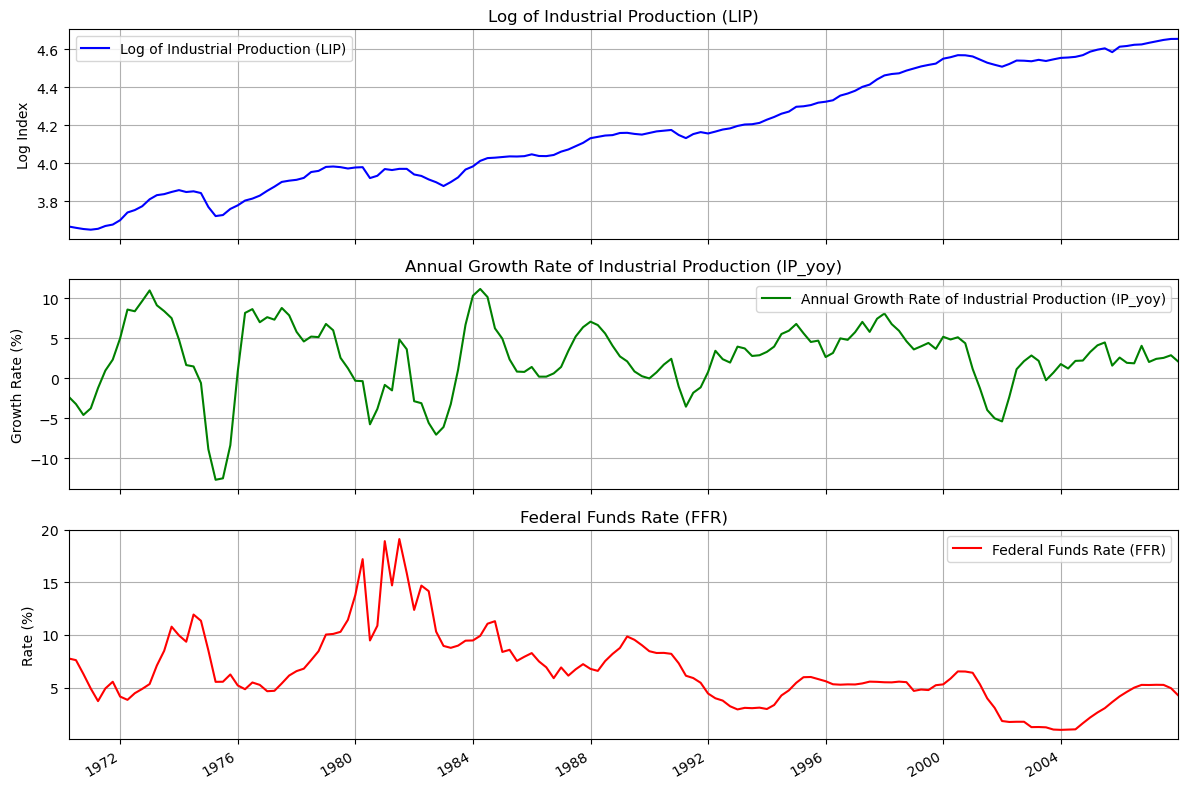

In [6]:
import matplotlib.pyplot as plt

# Create a new figure
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Plot the log of industrial production (LIP)
axes[0].plot(data_quarterly.index, data_quarterly['LIP'], label='Log of Industrial Production (LIP)', color='blue')
axes[0].set_title('Log of Industrial Production (LIP)')
axes[0].set_ylabel('Log Index')
axes[0].legend()

# Plot the annual growth rate of industrial production (IP_yoy)
axes[1].plot(data_quarterly.index, data_quarterly['IP_yoy'], label='Annual Growth Rate of Industrial Production (IP_yoy)', color='green')
axes[1].set_title('Annual Growth Rate of Industrial Production (IP_yoy)')
axes[1].set_ylabel('Growth Rate (%)')
axes[1].legend()

# Plot the Federal Funds Rate (FFR)
axes[2].plot(data_quarterly.index, data_quarterly['FFR'], label='Federal Funds Rate (FFR)', color='red')
axes[2].set_title('Federal Funds Rate (FFR)')
axes[2].set_ylabel('Rate (%)')
axes[2]


for ax in axes:
    ax.grid(True)
    ax.legend()
    ax.set_xlim(data_quarterly.index.min(), data_quarterly.index.max())

# Format the x-axis
plt.gcf().autofmt_xdate()
plt.tight_layout()

# Show the plot
plt.show()

We want to analyze the effects of monetary policy on output, which we measure with the index of industrial production (IP). To do so, we run the regression:
$$
Y_t = \alpha + \beta \Delta r_{t-1} + \epsilon_t
$$
where $Y_t$ is the output growth, $\Delta r_{t-1}$ is the lagged change in the federal funds rate, and $\epsilon_t$ is the error term.

In [7]:
import statsmodels.api as sm

# Create a new DataFrame with the necessary columns
data_ols = data_quarterly[['IP_yoy', 'FFR_change_lag1', 'intercept']].copy()

# Fit the OLS model using statsmodels
model = sm.OLS(data_ols['IP_yoy'], data_ols[['intercept', 'FFR_change_lag1']])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 IP_yoy   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     11.82
Date:                Thu, 08 May 2025   Prob (F-statistic):           0.000760
Time:                        17:46:23   Log-Likelihood:                -432.26
No. Observations:                 152   AIC:                             868.5
Df Residuals:                     150   BIC:                             874.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           2.5410      0.340     

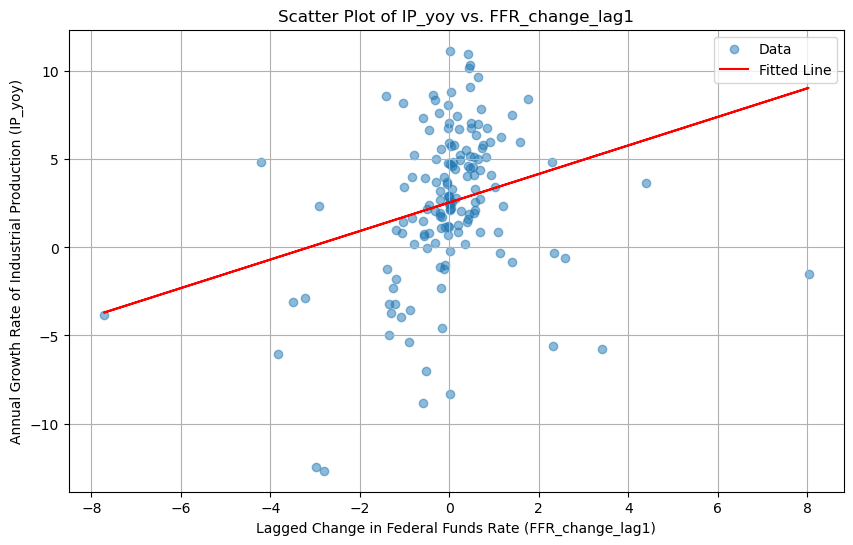

In [8]:
# Generate scatter plot with data and fitted line
plt.figure(figsize=(10, 6))
plt.scatter(data_ols['FFR_change_lag1'], data_ols['IP_yoy'], alpha=0.5, label='Data')
plt.plot(data_ols['FFR_change_lag1'], results.fittedvalues, color='red', label='Fitted Line')
plt.title('Scatter Plot of IP_yoy vs. FFR_change_lag1')
plt.xlabel('Lagged Change in Federal Funds Rate (FFR_change_lag1)')
plt.ylabel('Annual Growth Rate of Industrial Production (IP_yoy)')
plt.legend()
plt.grid(True)
plt.show()


An increase in the Federal Funds Rate is associated with an increase in output growth. This is inconsistent with the idea that an increase in interest rates reduces consumption and investment, which in turn reduces output growth.

Potential reasons for this inconsistency are:
- Simultaneity: the Federal Reserve may raise interest rates in response to an increase in output growth. Lagging the change in the interest rate by one period may not be enough to eliminate this simultaneity bias.
- Omitted variable bias: there may be other variables that affect both output growth and the Federal Funds Rate, leading to a spurious correlation between the two.


The series `RRSHOCK` in the dataset provided is a measure of monetary policy shocks. Test if this series is a suitable instrument for monetary policy changes.

In [9]:
RRSHOCKS_sum = data['RRSHOCK'].resample('QE').sum()
# add a new column to the data_quarterly DataFrame
data_quarterly = pd.merge(data_quarterly, RRSHOCKS_sum, left_index=True, right_index=True)
data_quarterly.head()

,FFR,LIP,FFR_change,FFR_change_lag1,IP_yoy,intercept,RRSHOCK
DATES,,,,,,,
1970-03-31,7.76,3.668085,-1.21,-0.18,-2.293243,1,-0.570515
1970-06-30,7.60,3.661105,-0.16,-1.21,-3.216004,1,-0.051167
1970-09-30,6.29,3.654855,-1.31,-0.16,-4.574587,1,-0.933303
1970-12-31,4.90,3.651279,-1.39,-1.31,-3.745562,1,-0.626705
1971-03-31,3.71,3.655951,-1.19,-1.39,-1.213403,1,-0.864555


In [10]:
# Test if RRSHOCK is a suitable instrument for FFR_change
# First stage regression: FFR_change on RRSHOCK
model_first_stage = sm.OLS(data_quarterly['FFR_change'], data_quarterly[['RRSHOCK', 'intercept']])
results_first_stage = model_first_stage.fit()
FFR_change_fitted = results_first_stage.fittedvalues
print(results_first_stage.summary())

                            OLS Regression Results                            
Dep. Variable:             FFR_change   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     229.0
Date:                Thu, 08 May 2025   Prob (F-statistic):           5.37e-32
Time:                        17:46:23   Log-Likelihood:                -201.02
No. Observations:                 152   AIC:                             406.0
Df Residuals:                     150   BIC:                             412.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RRSHOCK        1.9079      0.126     15.133      0.0

Text(0.5, 1.0, 'Scatter Plot of Romer-Romer Shock vs. Federal Funds Rate')

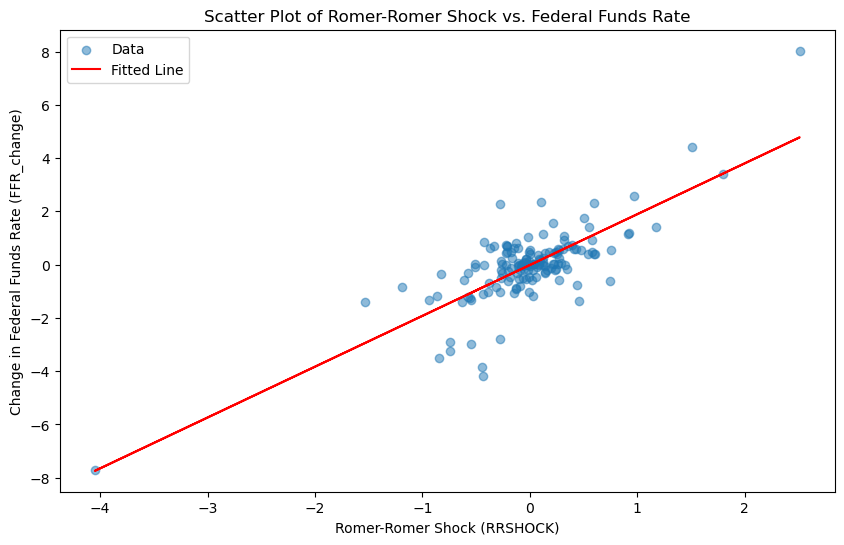

In [11]:
# Generate a scatter plot of the `RRSHOCK` series against the Federal Funds Rate
plt.figure(figsize=(10, 6))
plt.scatter(data_quarterly['RRSHOCK'], data_quarterly['FFR_change'], alpha=0.5, label='Data')
plt.plot(data_quarterly['RRSHOCK'], FFR_change_fitted, color='red', label='Fitted Line')
plt.xlabel('Romer-Romer Shock (RRSHOCK)')
plt.ylabel('Change in Federal Funds Rate (FFR_change)')
plt.legend()
plt.title('Scatter Plot of Romer-Romer Shock vs. Federal Funds Rate')

Runs a 2SLS regression for the change in industrial production and using the series of monetary policy shocks as an instrument.

In [12]:
# Rename the FFR_change_fitted series and concatenate it with the DataFrame
data_second_stage = pd.merge(data_quarterly, FFR_change_fitted.rename('FFR_change_fitted'), left_index=True, right_index=True).copy()

# Keep in mind that we want to use the lagged value of the fitted FFR_change in the second stage regression
data_second_stage['FFR_change_fitted_lag1'] = data_second_stage['FFR_change_fitted'].shift(1)

# Drop rows with NaN values
data_second_stage.dropna(inplace=True)

# Display the resulting DataFrame
data_second_stage.head()

,FFR,LIP,FFR_change,FFR_change_lag1,IP_yoy,intercept,RRSHOCK,FFR_change_fitted,FFR_change_fitted_lag1
DATES,,,,,,,,,
1970-06-30,7.60,3.661105,-0.16,-1.21,-3.216004,1,-0.051167,-0.115423,-1.106303
1970-09-30,6.29,3.654855,-1.31,-0.16,-4.574587,1,-0.933303,-1.798478,-0.115423
1970-12-31,4.90,3.651279,-1.39,-1.31,-3.745562,1,-0.626705,-1.213509,-1.798478
1971-03-31,3.71,3.655951,-1.19,-1.39,-1.213403,1,-0.864555,-1.667311,-1.213509
1971-06-30,4.91,3.670797,1.20,-1.19,0.969216,1,0.922052,1.741413,-1.667311


In [13]:
# Run the second stage regression: IP_yoy on FFR_change_fitted
model_second_stage = sm.OLS(data_second_stage['IP_yoy'], data_second_stage[['intercept', 'FFR_change_fitted_lag1']])
results_second_stage = model_second_stage.fit()
print(results_second_stage.summary())

                            OLS Regression Results                            
Dep. Variable:                 IP_yoy   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.059
Date:                Thu, 08 May 2025   Prob (F-statistic):              0.305
Time:                        17:46:23   Log-Likelihood:                -434.48
No. Observations:                 151   AIC:                             873.0
Df Residuals:                     149   BIC:                             879.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  2

Note: the effect of a change in the Federal Funds Rate is insignificant now.

In [14]:
# There are several external modules that allow to do this. Linearmodels is another one.
from linearmodels.iv import IV2SLS
data_quarterly2 = data_quarterly.copy()
data_quarterly2['RRSHOCK_lag1'] = data_quarterly2['RRSHOCK'].shift(1)
data_quarterly2 = data_quarterly2.dropna()

mod = IV2SLS.from_formula('IP_yoy ~ 1 + [FFR_change_lag1 ~ RRSHOCK_lag1]', data_quarterly2)

IVresults = mod.fit()
print(IVresults)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 IP_yoy   R-squared:                      0.0468
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0404
No. Observations:                 151   F-statistic:                    0.7760
Date:                Thu, May 08 2025   P-value (F-stat)                0.3784
Time:                        17:46:23   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           2.5590     0.3417     7.4900     0.0000      1.8894      3.2287
FFR_change_lag1     0.3224     0

Lag by 4 quarters:

In [15]:
# There are several external modules that allow to do this. Linearmodels is another one.
data_quarterly2 = data_quarterly.copy()
data_quarterly2['FFR_change_lag4'] = data_quarterly2['FFR_change'].shift(4)
data_quarterly2['RRSHOCK_lag4'] = data_quarterly2['RRSHOCK'].shift(4)
data_quarterly2 = data_quarterly2.dropna()

mod = IV2SLS.from_formula('IP_yoy ~ 1 + [FFR_change_lag4 ~ RRSHOCK_lag4]', data_quarterly2)

IVresults = mod.fit()
print(IVresults)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 IP_yoy   R-squared:                      0.0073
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0005
No. Observations:                 148   F-statistic:                    3.3469
Date:                Thu, May 08 2025   P-value (F-stat)                0.0673
Time:                        17:46:23   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           2.6635     0.3481     7.6514     0.0000      1.9812      3.3457
FFR_change_lag4    -0.6584     0